## (1) Import libraries

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from kats.consts import TimeSeriesData
from kats.utils.simulator import Simulator
from kats.detectors.cusum_detection import CUSUMDetector
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType
from kats.detectors.robust_stat_detection import RobustStatDetector

from kats.detectors.outlier import OutlierDetector

from kats.detectors.trend_mk import MKDetector

import warnings
warnings.simplefilter(action='ignore')

In [95]:
# Record version of key libraries
from importlib.metadata import version

print('kats==%s' % version('kats'))

kats==0.1.0


## (2) Get data

In [97]:
# Create synthetic data
ts_sim = Simulator(n=450, start='2020-01-01', freq='D')

# Create synthetic data for change detection
change_ts = ts_sim.level_shift_sim(noise=0.05, seasonal_period=1)

# Create synthetic data for trend detection
trend_ts = ts_sim.trend_shift_sim(noise=200, seasonal_period=7, seasonal_magnitude=0.007,
                               cp_arr=[250], intercept = 10000, trend_arr=[40,-20])

In [98]:
# Read local data
outlier_data_df = pd.read_csv("../data/air_passengers.csv")

# Set column names so that constructor can recognise the data
# time column is required to be recognised as dates, and any number of value columns can be present
outlier_data_df.columns = ['time', 'value']

# Add outliers into data
outlier_data_df.loc[outlier_data_df.time == '1950-12-01','value']*=5
outlier_data_df.loc[outlier_data_df.time == '1959-12-01', 'value']*=4

# Convert data object from pandas dataframe into kats object
outlier_ts = TimeSeriesData(outlier_data_df, time_col_name='time')

## (3) Perform change detection

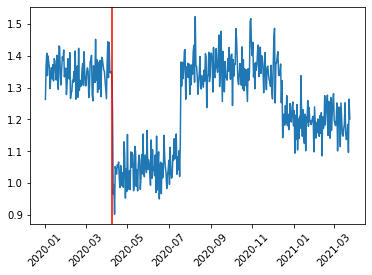

_start_time  _end_time  _confidence _direction  _cp_index      _mu0  \
0  2020-04-08 2020-04-08          1.0   decrease         98  1.345995   

       _mu1    _delta  _llr_int       _llr  _regression_detected  \
0  1.222166 -0.123829       inf  68.891923                  True   

   _stable_changepoint      _p_value  _p_value_int  
0                 True  1.110223e-15           NaN

In [79]:
# Perform change detection using CUSUM 

# Detect a change point
cusum_detector = CUSUMDetector(change_ts) # only detects one change point
cusum_detector.data.time.name = 'time' # NOTE - this to overcome a bug in detector.plot where this attribute is not set properly
cusum_detector.data.value.name = 'value' # NOTE - this to overcome a bug in detector.plot where this attribute is not set properly
cusum_change_points = cusum_detector.detector()

plt.xticks(rotation=45)
cusum_detector.plot(cusum_change_points)
plt.show()

# Convert change point stats into df
cp_df_list = []
for cp in cusum_change_points:
    stat, metadata = cp

    cp_df = pd.concat([
        pd.DataFrame(stat.__dict__, index=[0]),
        pd.DataFrame(metadata.__dict__, index=[0])
    ], axis=1)

    cp_df_list.append(cp_df)

comb_cp_df = pd.concat(cp_df_list, axis=0).reset_index(drop=True)

display(comb_cp_df)

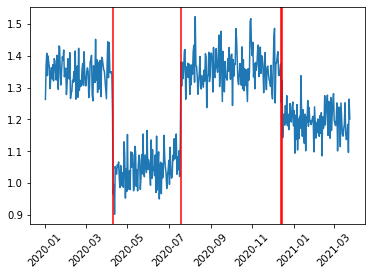

_start_time  _end_time  _confidence  \
0  2020-04-09 2020-04-09     0.975266   
1  2020-07-19 2020-07-19     0.974624   
2  2020-12-13 2020-12-13     0.636433   
3  2020-12-15 2020-12-15     0.750967   

                                _detector_type  \
0  <class 'kats.detectors.bocpd.BOCPDetector'>   
1  <class 'kats.detectors.bocpd.BOCPDetector'>   
2  <class 'kats.detectors.bocpd.BOCPDetector'>   
3  <class 'kats.detectors.bocpd.BOCPDetector'>   

                              _model _ts_name  
0  BOCPDModelType.NORMAL_KNOWN_MODEL    value  
1  BOCPDModelType.NORMAL_KNOWN_MODEL    value  
2  BOCPDModelType.NORMAL_KNOWN_MODEL    value  
3  BOCPDModelType.NORMAL_KNOWN_MODEL    value

In [80]:
# Perform change detection using Bayesian Online Change Point Detection (BOCPD) 

# Detect a change point
bocpd_detector = BOCPDetector(change_ts)
bocpd_change_points = bocpd_detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL # this is the default choice
)

plt.xticks(rotation=45)
bocpd_detector.plot(bocpd_change_points)
plt.show()

# Convert change point stats into df
cp_df_list = []
for cp in bocpd_change_points:
    stat, metadata = cp

    cp_df = pd.concat([
        pd.DataFrame(stat.__dict__, index=[0]),
        pd.DataFrame(metadata.__dict__, index=[0])
    ], axis=1)

    cp_df_list.append(cp_df)

comb_cp_df = pd.concat(cp_df_list, axis=0).reset_index(drop=True)

display(comb_cp_df)

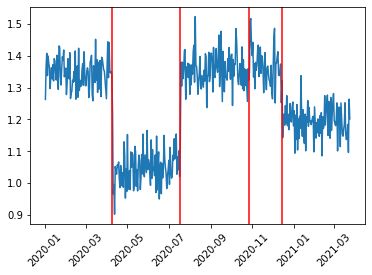

_start_time  _end_time  _confidence   _metric  _index
0  2020-04-08 2020-04-08     0.999992  0.120268      98
1  2020-07-17 2020-07-17     0.998194 -0.079873     198
2  2020-10-28 2020-10-28     0.999664 -0.093469     301
3  2020-12-15 2020-12-15     0.993338  0.069422     349

In [82]:
# Perform change detection using RobustStat

# Detect a change point
rstat_detector = RobustStatDetector(change_ts)
rstat_change_points = rstat_detector.detector()

plt.xticks(rotation=45)
rstat_detector.plot(rstat_change_points)
plt.show()

# Convert change point stats into df
cp_df_list = []
for cp in rstat_change_points:
    stat, metadata = cp

    cp_df = pd.concat([
        pd.DataFrame(stat.__dict__, index=[0]),
        pd.DataFrame(metadata.__dict__, index=[0])
    ], axis=1)

    cp_df_list.append(cp_df)

comb_cp_df = pd.concat(cp_df_list, axis=0).reset_index(drop=True)

display(comb_cp_df)

## (4) Perform outlier detection

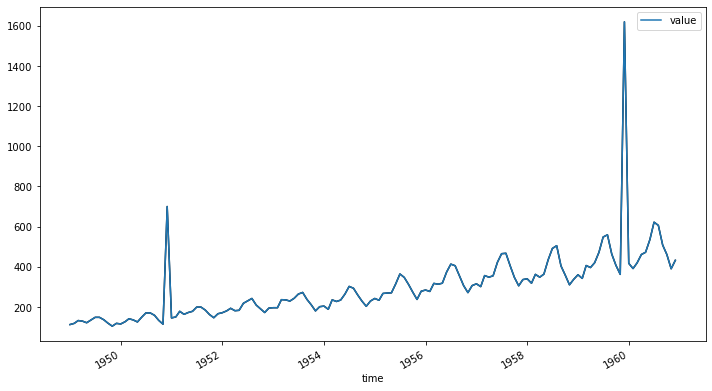

In [87]:
# Visualise data
outlier_ts.plot(cols=['value'])
plt.show()


In [89]:
# Run outlier detection
ts_outlierDetection = OutlierDetector(outlier_ts, 'additive') # call OutlierDetector
ts_outlierDetection.detector() # apply OutlierDetector

print(ts_outlierDetection.outliers)

[[Timestamp('1950-12-01 00:00:00'), Timestamp('1959-11-01 00:00:00'), Timestamp('1959-12-01 00:00:00')]]


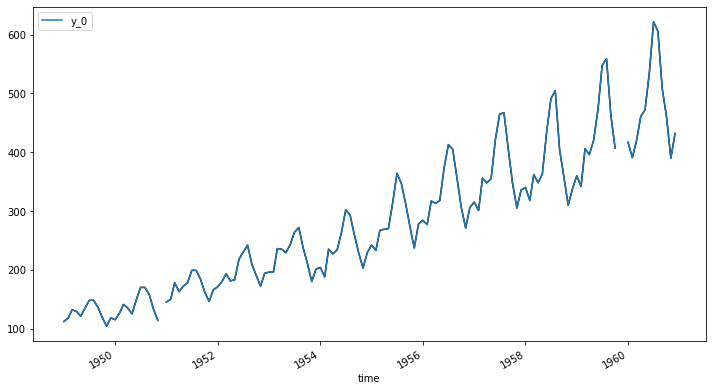

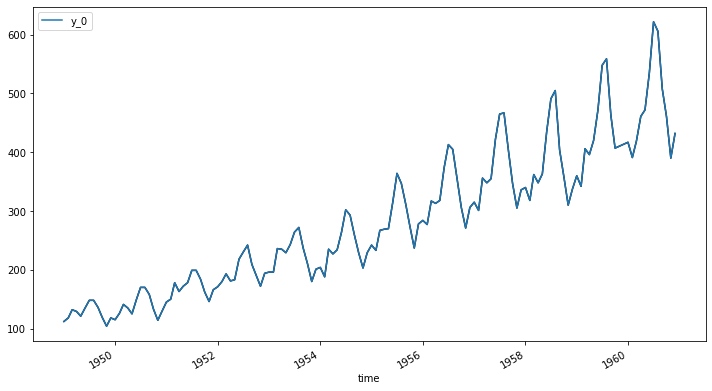

In [93]:
# Fix outliers with removal
outlier_ts_removed = ts_outlierDetection.remover(interpolate = False)

# Fix outliers with interpolation
outlier_ts_interpolated = ts_outlierDetection.remover(interpolate = True)

# Visualise data
outlier_ts_removed.plot(cols=['y_0'])
outlier_ts_interpolated.plot(cols=['y_0'])
plt.show()

## (5) Perform trend detection

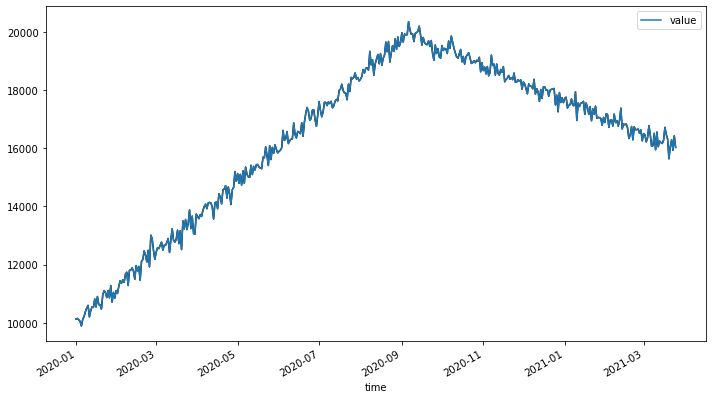

In [99]:
# Visualise data
trend_ts.plot(cols=['value'])
plt.show()

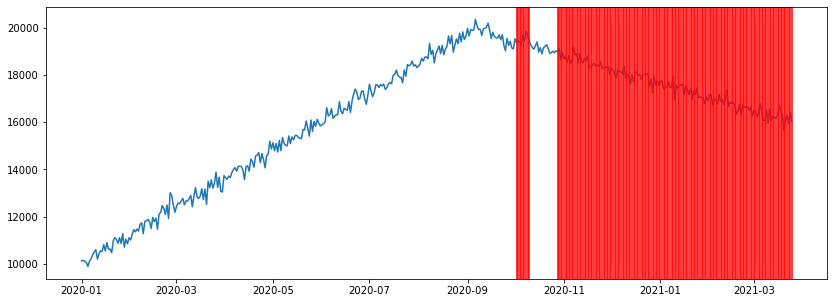

[(TimeSeriesChangePoint(start_time: 2020-10-02 00:00:00, end_time: 2020-10-02 00:00:00, confidence: 0.9999999136388094), <kats.detectors.trend_mk.MKMetadata object at 0x7f7b06b05250>), (TimeSeriesChangePoint(start_time: 2020-10-03 00:00:00, end_time: 2020-10-03 00:00:00, confidence: 0.9999999906787311), <kats.detectors.trend_mk.MKMetadata object at 0x7f7b06b056d0>), (TimeSeriesChangePoint(start_time: 2020-10-04 00:00:00, end_time: 2020-10-04 00:00:00, confidence: 0.9999999980532939), <kats.detectors.trend_mk.MKMetadata object at 0x7f7b06b054c0>), (TimeSeriesChangePoint(start_time: 2020-10-05 00:00:00, end_time: 2020-10-05 00:00:00, confidence: 0.9999999991320236), <kats.detectors.trend_mk.MKMetadata object at 0x7f7b06b05460>), (TimeSeriesChangePoint(start_time: 2020-10-06 00:00:00, end_time: 2020-10-06 00:00:00, confidence: 0.9999999991320236), <kats.detectors.trend_mk.MKMetadata object at 0x7f7b06b058e0>)]


In [104]:
# Detect trend
trend_detector = MKDetector(data=trend_ts, threshold=.8)
trend_time_points = trend_detector.detector(direction='down', window_size=20, freq='weekly')

# Plot the results
trend_detector.plot(trend_time_points)
plt.show()

print(trend_time_points[:5])